
# Task: Build a Neural Network from Scratch

### A Note Before You Begin: The Spirit of this Exercise

Welcome! This notebook is designed as a **hands-on learning experience**. The primary goal is not just to get the code running, but to help you build a deep, intuitive understanding of how neural networks work from the inside out.

To achieve this, please keep the following in mind:

*   **Embrace the Simplicity:** You might notice that some of the provided code is intentionally simplified or "trivial." This is done on purpose to isolate and highlight the core concept of each section.

*   **The Value is in the Struggle:** The real learning happens when you tackle the `TODO` sections. We strongly encourage you to **try solving them on your own first**. Grappling with the problems, hitting walls, and working through the logic is the most effective way to make these concepts stick.

*   **Try Not to Cheat Yourself:** It can be tempting to look ahead or search for a direct solution online. We ask that you treat this as a personal challenge. The journey of figuring it out is far more valuable than the final answer itself.

Happy coding, and enjoy the process of building your own neural network!

---
You will be completing the code in sections marked with `TODO`.

## Part 1: Understanding Derivatives

Before we build a network, let's refresh our understanding of derivatives. The derivative of a function at a certain point tells us the rate of change or the slope of the function at that point. We can approximate it numerically.

### 1.1 Univariate Function

Let's start with a simple function `f(x) = 3x^2 - 4x + 5`.

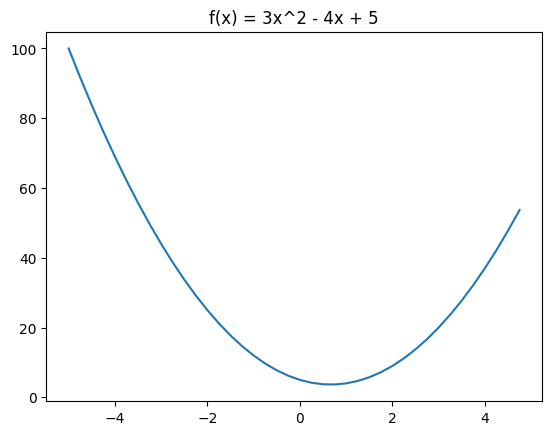

In [186]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

def f(x):
  return 3*x**2 - 4*x + 5

# Let's see how the function looks
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.title("f(x) = 3x^2 - 4x + 5")
plt.show()

The derivative of `f(x)` with respect to `x` is `f'(x) = 6x - 4`. At `x = 3.0`, the derivative is `6*3.0 - 4 = 14.0`.

We can approximate this by "nudging" `x` by a very small amount `h` and observing the change in `f(x)`.

In [187]:
# TASK 1.1: Find the derivative of f(x) w.r.t x at x=3.0 numerically.
# The formula for the numerical derivative is (f(x+h) - f(x)) / h
h = 0.0001
x = 3.0

# TODO: Calculate the value of the function at x
f_x = f(x)

# TODO: Calculate the value of the function at x + h
f_x_plus_h = f(x + h)

# TODO: Calculate the slope (the numerical derivative)
slope = (f_x_plus_h - f_x) / h

print(f"The exact derivative at x=3.0 is 14.0")
print(f"The numerical derivative is: {slope}")

The exact derivative at x=3.0 is 14.0
The numerical derivative is: 14.000300000063248


### 1.2 Multivariate Function

Now let's consider a function with multiple inputs, `d = a*b + c`. We can find the *partial derivative* with respect to each input. For example, how does `d` change when we nudge `a`?

In [188]:
# TASK 1.2: Find the partial derivative of d with respect to 'a' and 'b'.
# The partial derivative of d with respect to 'a' is b.
# The partial derivative of d with respect to 'b' is a.

h = 0.0001
a = 2.0
b = -3.0
c = 10.0

# Initial expression
d1 = a*b + c

# --- Derivative w.r.t 'a' ---
# TODO: Nudge 'a' by h and recalculate the expression for d2
a_new = a + h   # cause the change is only in a 
d2_wrt_a = (a+h)*-3.0 + 10.0  # b, c are constants
slope_a = (d2_wrt_a - d1) / h
print(f"Partial derivative w.r.t 'a': {slope_a}, Expected: {b}")

# --- Derivative w.r.t 'b' ---
# TODO: Nudge 'b' by h and recalculate the expression for d2
b_new = b + h
d2_wrt_b = 2.0*(b+h) + 10.0
slope_b = (d2_wrt_b - d1) / h
print(f"Partial derivative w.r.t 'b': {slope_b}, Expected: {a}")

Partial derivative w.r.t 'a': -3.000000000010772, Expected: -3.0
Partial derivative w.r.t 'b': 2.0000000000042206, Expected: 2.0


## Part 2: Creating an Automatic Differentiation Engine

Manually calculating derivatives is tedious. Let's build a `Value` class that keeps track of these operations and can automatically compute gradients for us!

### 2.1 The `Value` Object

We'll create a `Value` class that holds a single scalar value. We will then overload operators like `+` and `*` to create a computation graph.

In [189]:
class Value:
    """
    A class for a value that can be used in a computational graph.
    
    Attributes:
    -----------
    data : float
        The scalar data held by the Value instance.
    _prev : set
        A set of previous Value instances that are the parents of this Value.
    _op : str
        The operation that produced this Value instance (e.g., '+', '*').
    label : str
        A label for visualization purposes.
    grad : float
        The gradient of the final output with respect to this value.
    """
    
    # TASK 2.1: Implement the functions below.
    def __init__(self, data, _children=(), _op='', label=''):
        # Initialize all the attributes
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        pass

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        # TODO: Implement the addition operation.
        other = other if isinstance(other, Value) else Value(other)  # handle non-Value operands
        # forward pass: build graph + history
        out = Value(data = self.data + other.data, _children=(self, other), _op='+', label='(a+b)')
        return out

    def __mul__(self, other):
        # TODO: Implement the multiplication operation.
        other = other if isinstance(other, Value) else Value(other)
        # forward pass: build graph + history
        out = Value(data = self.data * other.data, _children=(self, other), _op='*', label='(a*b)')
        return out
    
    
# --- You can test your implementation here ---
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'

print(d)        # Expected: Value(data=4.0)
print(d._prev)  # Expected: {Value(data=10.0), Value(data=-6.0)}
print(d._op)    # Expected: '+'

Value(data=4.0)
{Value(data=10.0), Value(data=-6.0)}
+


### 2.2 Visualizing the Computation Graph

If your `Value` class is implemented correctly, the following code will visualize the expression `L = d * f` as a graph.

*(The visualization code is provided for you)*

First you need to install the `graphviz` package if you haven't already:

```bash
sudo apt install graphviz
pip install graphviz
```
Or for Windows users, you can install by downloading the installer from the [Graphviz website](https://graphviz.org/download/).

then install the Python package:
```bash
pip install graphviz
```


In [190]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

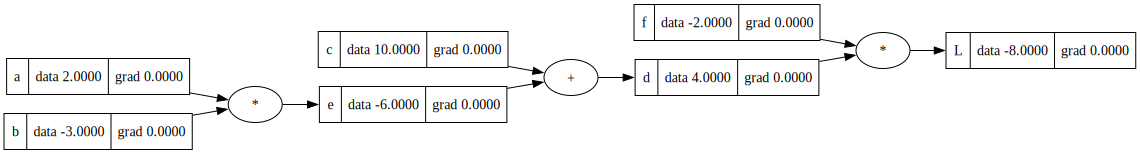

In [191]:
# --- Create and visualize the graph ---
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

draw_dot(L)

### 2.3 Manual Backpropagation

Backpropagation is the process of applying the chain rule to compute the gradient of the final output (e.g., `L`) with respect to every node in the graph. Let's do it manually first.

**Expression:** `L = d * f`

The derivative of `L` with respect to itself is 1.
`L.grad = 1.0`

Using the multiplication rule, `dL/dd = f` and `dL/df = d`.

In [192]:
# TASK 2.3: Manually calculate and set the gradients for each node.
# L.grad = 1.0

# TODO: Calculate the gradient for d and f

d.grad = f.data * L.grad  # dL/dd (partial)
f.grad = d.data * L.grad  # dL/df (partial)

# verify
print(d.grad)  # Expected: -3.0
print(f.grad)  # Expected: 10.0

-0.0
0.0


- L.grad by defult is set to zero as any created object from values -> must modify firstly

In [193]:
L.grad = 1.0

d.grad = f.data * L.grad  # dL/dd (partial)
f.grad = d.data * L.grad  # dL/df (partial)

# verify
print(d.grad)  # Expected: -2.0
print(f.grad)  # Expected:  4.0 (-6.0 + 10.0)

-2.0
4.0


Now we "backpropagate" further.

**Expression:** `d = e + c`

The gradient "flows" through the `+` node. Using the chain rule, `dL/dc = (dL/dd) * (dd/dc)`.
Since `dd/dc = 1.0` and `dd/de = 1.0`:
`dL/dc = d.grad * 1.0`
`dL/de = d.grad * 1.0`

In [194]:
# TODO: Calculate the gradient for c and e
c.grad = d.grad * 1.0  # dL/dc 
e.grad = d.grad * 1.0  # dL/de 

And one last step.

**Expression:** `e = a * b`

Using the chain rule again, `dL/da = (dL/de) * (de/da)`.
Since `de/da = b` and `de/db = a`:
`dL/da = e.grad * b.data`
`dL/db = e.grad * a.data`

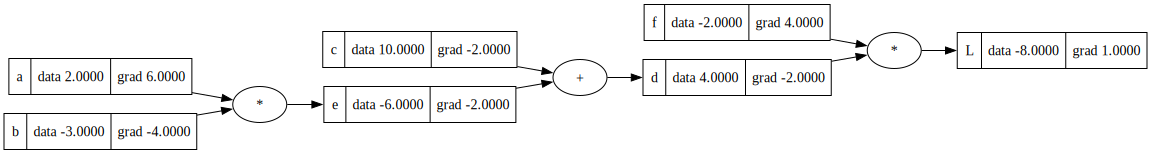

In [195]:
# TODO: Calculate the gradient for a and b
a.grad = e.grad * b.data  # dL/da
b.grad = e.grad * a.data  # dL/db

# After all gradients are set, you can visualize the graph again to see them!
draw_dot(L)

### 2.4 Automating Backpropagation

Doing this manually is not scalable. Let's automate it! We will add a `_backward` function to each operation and a main `backward()` method to orchestrate the process.

Let's start with a new `Value` class, this time with a place for our backward functions.

In [196]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # This will store the function to run during backprop
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)  # handle non-Value operands
        # forward pass: build graph + history
        out = Value(data = self.data + other.data, _children=(self, other), _op='+', label='(a+b)')
        
        # TASK 2.4.1: Implement the _backward function for addition.
        def _backward():
            # The gradient of the output (out) should be propagated to the inputs (self, other).
            # The local derivative for '+' is 1.0.
            # Use the chain rule: self.grad += local_derivative * out.grad
            # we use += as the variable might exist in multiple passes
            
            self.grad  += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward       
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        # forward pass: build graph + history
        out = Value(data = self.data * other.data, _children=(self, other), _op='*', label='(a*b)')
        
        # TASK 2.4.2: Implement the _backward function for multiplication.
        def _backward():
            # The local derivative for '*' is the other value.
            # Use the chain rule
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    # activation functions
    def tanh(self):
        z = self.data
        # Forward pass
        t = (math.exp(2*z) - 1)/(math.exp(2*z) + 1)
        out = Value(t, (self, ), 'tanh', label='tanh')

        # TASK 2.4.3: Implement the _backward function for tanh.
        def _backward():
            # The local derivative of tanh(z) is sech^2(z) == 1 - tanh^2(z)
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def ReLU(self):
        z = self.data
        # Forward pass
        R = max(0, z)  # Zero for z =< 0 and z for z > 0 
        out = Value(R, (self, ), 'ReLU', label='ReLU')

        def _backward():
            # The local derivative of ReLU(z) is 1 if z > 0 and Zero for z =< 0
            self.grad += (1 if z > 0 else 0) * out.grad
        out._backward = _backward
        return out

    # backpropagation
    def backward(self):
        # This function orchestrates the backward pass.
        # It needs to call _backward() on all nodes in the graph in the correct order.
        
        # TASK 2.4.4: Implement the main backward method.
        # 1. (Already implemented) Create a topological sort of the graph to ensure we process nodes in the correct order.
        topo = []
        visited = set()
        def build_topo(v):  # DFS
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        
        # 2. Set the gradient of the final output node to 1.0.
        self.grad = 1.0  # always done for the final output node dL/dL = 1

        # 3. Iterate through the nodes in reverse topological order and call their _backward() function.
        for node in reversed(topo): 
            node._backward()

**Let's test your automated backpropagation on a neuron.**

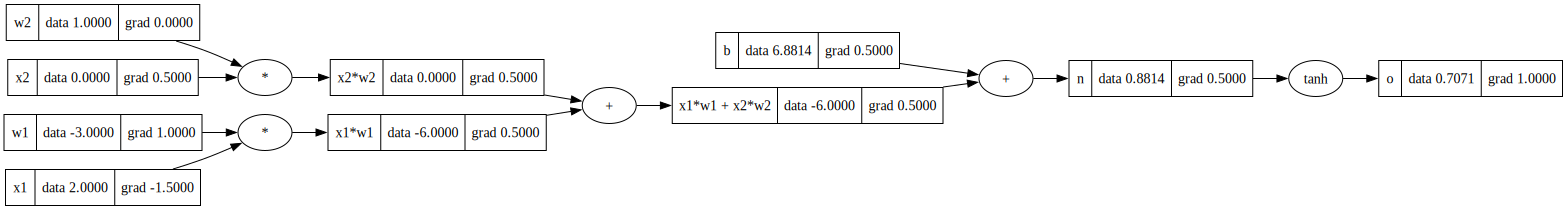

In [197]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

# Run the backward pass
o.backward()

# Visualize the result - you should see all the gradients now!
# Calculate the gradients manually to verify your implementation
draw_dot(o)

## Part 3: Building a Neural Network

Now that we have our `Value` object with automatic differentiation, we can build neural network components.

We will create three classes: `Neuron`, `Layer`, and `MLP` (Multi-Layer Perceptron).

*(A `Module` class is provided to help with managing parameters and gradient resetting to 0).*

In [203]:
class Module:  # Module is a simplified version of PyTorch’s nn.Module
    def zero_grad(self):
        for p in self.parameters():  # each parameter is a value object
            p.grad = 0   # Before starting a new iteration, we must reset all gradients to 0.

    def parameters(self):  # later Neuron, Layer, MLP will override...
        return [] 

The output of a `Neuron` is given by:

$\text{output}=\tanh\left(\sum_{i=1}^{n} w_i x_i + b\right)$

Where:
- \( w_i \) = weight for input \( x_i \)  
- \( x_i \) = input value  
- \( b \) = bias term  
- \( n \) = number of inputs  
- \( tanh \) = activation function


In [204]:
class Neuron(Module):
  # TASK 3.1: Complete the Neuron class.
  def __init__(self, n_in):
    # A neuron has 'n_in' weights (w) -> a vector of values and one bias (b).
    # Initialize weights randomly between -1 and 1.
    #self.w = [Value(random.uniform(-1,1)) for _ in range(n_in)] 
    #self.b = Value(random.uniform(-1,1))
    # HE initialization
    std = math.sqrt(2.0 / n_in)
    self.w = [Value(random.gauss(0, std)) for n in range(n_in)]
    self.b = Value(0.0)
    

  def __call__(self, x):  # x is a vector of input values
    # This should compute the summation of the neuron.
    # Formula: z = w[0]*x[0] + w[1]*x[1] + ... + b, weighted sum + bias
    z = sum((w * x for w, x in zip(self.w, x)), self.b)  
    # Then pass through non-linearity activation function like tanh.
    return z.tanh()
    #return z.ReLU()  # Using ReLU activation function for better performance
  
  def parameters(self):  # store used weights and bias in forward pass
    return self.w + [self.b] 

In [205]:
class Layer(Module):
  # TASK 3.2: Complete the Layer class.
  def __init__(self, n_in, n_out):
    # A layer is a list of neurons.
    # n_in the inputs of each neuron (number of neurons in previous layer)
    # n_out number of neurons in current layer (n_in for neurons of next layer)
    self.neurons = [Neuron(n_in) for neuron in range(n_out)]
  
  def __call__(self, x):
    # When you call a layer, you call each neuron with the input x.
    outs = [neuron(x) for neuron in self.neurons]  # input vector for each neuron in next layer
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    # A layer's parameters are all the parameters from all its neurons.
    return [p for neuron in self.neurons for p in neuron.parameters()]

In [206]:
class MLP(Module):
  # TASK 3.3: Complete the MLP class.
  def __init__(self, n_in, n_outs):
    # 'n_in' is number of features in the input layer
    # 'n_outs' is a list of layer sizes.
    # e.g., MLP(3, [4, 4, 1]) is a network with 3 inputs, two hidden layers of 4 neurons, and one output neuron.
    sz = [n_in] + n_outs
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_outs))]
  
  def __call__(self, x):
    # Pass the input 'x' through all the layers sequentially.
    for layer in self.layers:
      z = layer(x)
    return z

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

Value(data=-0.16522701391969466)


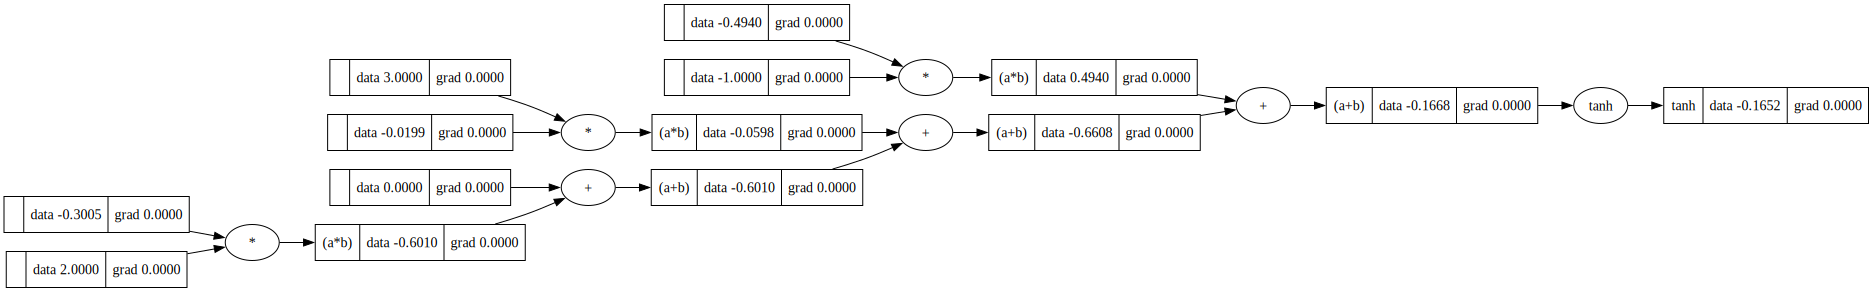

In [207]:
# --- You can test your network here ---
x = [2.0, 3.0, -1.0]
model = MLP(3, [4, 4, 1])
output = model(x)
print(output)
draw_dot(output)

---

### `Dropout`
- skip next 2 cells if not required 

In [208]:

class Layer(Module):
    def __init__(self, n_in, n_out, dropout_p=0.0):
        # Initialize neurons and dropout probability
        self.neurons = [Neuron(n_in) for n in range(n_out)]
        self.dropout_p = dropout_p

    def __call__(self, x, training=True):
        # Forward pass through all neurons
        outs = [neuron(x) for neuron in self.neurons]

        if training and self.dropout_p > 0.0:
            # Apply inverted dropout
            for i in range(len(outs)):
                if random.random() < self.dropout_p:
                    outs[i] = Value(0.0)  # drop this neuron
                else:
                    outs[i] = outs[i] * (1.0 / (1 - self.dropout_p))  # scale kept neurons

        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [209]:
class MLP(Module):
    def __init__(self, n_in, n_outs, dropout_p=0.0):
        sz = [n_in] + n_outs
        # Pass dropout probability to all layers except output layer
        self.layers = [Layer(sz[i], sz[i+1], dropout_p if i < len(n_outs)-1 else 0.0) 
                       for i in range(len(n_outs))]

    def __call__(self, x, training=True):
        # Sequentially pass through layers
        for layer in self.layers:
            x = layer(x, training=training)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

Value(data=0.4751779152691367)


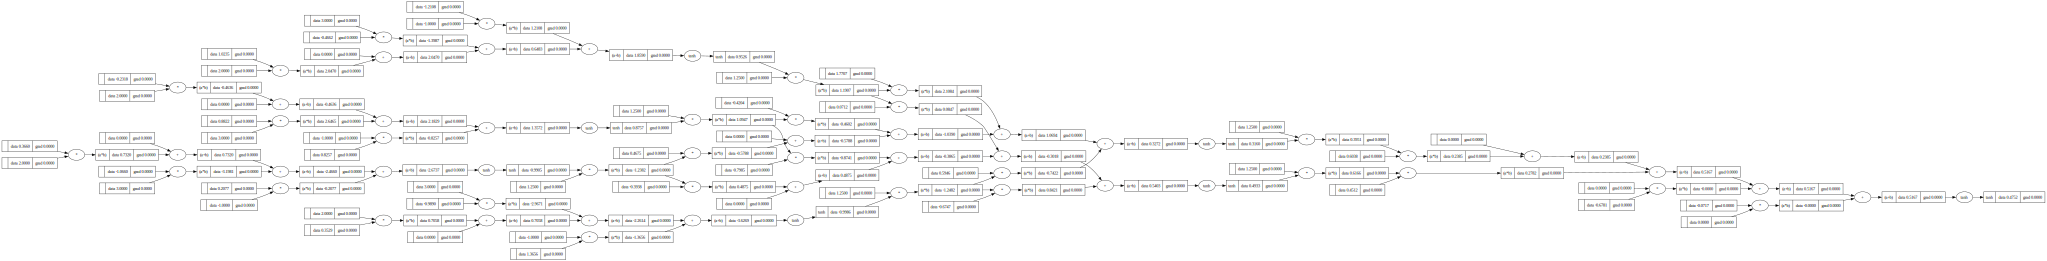

In [210]:
# --- You can test your network here ---
x = [2.0, 3.0, -1.0]
model = MLP(3, [4, 4, 1], dropout_p=0.2)
output = model(x, training=True)
print(output)
draw_dot(output)

## Part 4: Training the Network

Now for the exciting part! Let's train our network to fit some data. We'll use a simple dataset and the Mean Squared Error (MSE) loss function.

In [211]:
# Our dataset -> 4 samples each has 3 features
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
] 

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# Initialize the network
model = MLP(3, [4, 4, 1], dropout_p=0.2)

In [212]:
# --- Complete Value Class (Provided) ---
# extended version, including additional operations
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __neg__(self): # -self
        return self * -1

  def __radd__(self, other): # other + self
      return self + other

  def __sub__(self, other): # self - other
      return self + (-other)

  def __rsub__(self, other): # other - self
      return other + (-self)

  def __rmul__(self, other): # other * self
      return self * other

  def __truediv__(self, other): # self / other
      return self * other**-1

  def __rtruediv__(self, other): # other / self
      return other * self**-1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def sigmoid(self):
    x = self.data
    t = 1.0 / (1.0 + math.exp(-x))
    out = Value(t, (self, ), 'sigmoid')
    
    def _backward():
      self.grad += t * (1-t) * out.grad
    out._backward = _backward
    
    return out
  
  def ReLU(self):   # bonus activation function
    z = self.data
    # Forward pass
    R = max(0, z)  # Zero for z =< 0 and z for z > 0
    out = Value(R, (self,), 'ReLU', label='ReLU')

    def _backward():  
      # The local derivative of ReLU(z) is 1 if z > 0 and Zero for z =< 0
      self.grad += (1 if z > 0 else 0) * out.grad
    out._backward = _backward
    
    return out

  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

The `training loop` consists of four main steps:
1.  **Forward Pass:** Get predictions from the network.
2.  **Compute Loss:** See how wrong the predictions are.
3.  **Backward Pass:** Compute gradients for all parameters.
4.  **Update Parameters:** Nudge the parameters in the opposite direction of their gradient.

In [213]:
# TASK 4.1: Complete the training loop.
n_epochs = 20
lr = 0.1  # learning rate

for epoch in range(n_epochs):
    # 1. Forward Pass
    # TODO: Get predictions for each input in xs
    ypred = [model(x) for x in xs]  # pass input row by row

    # 2. Compute Loss (Mean Squared Error)
    # The formula is: sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    # We will use the full `Value` class from above for this, which supports more operations.
    # For now, let's assume `loss` is a `Value` object representing the MSE.
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # 3. Backward Pass
    # TODO: First, zero out the old gradients.
    model.zero_grad()
    # TODO: Then, run the backward pass to compute new gradients.
    loss.backward()


    # 4. Update Parameters
    # TODO: Loop through all parameters `p` in the network and update their data.
    for p in model.parameters():
        p.data = p.data - lr * p.grad
        
    print(f'Epoch {epoch+1} Loss: {loss.data:.4f}')

Epoch 1 Loss: 11.8260
Epoch 2 Loss: 2.1897
Epoch 3 Loss: 5.7676
Epoch 4 Loss: 1.1832
Epoch 5 Loss: 0.0235
Epoch 6 Loss: 2.0618
Epoch 7 Loss: 2.5096
Epoch 8 Loss: 0.4013
Epoch 9 Loss: 0.0325
Epoch 10 Loss: 0.0968
Epoch 11 Loss: 0.0172
Epoch 12 Loss: 0.0064
Epoch 13 Loss: 3.6500
Epoch 14 Loss: 1.2900
Epoch 15 Loss: 2.9171
Epoch 16 Loss: 3.5975
Epoch 17 Loss: 2.8278
Epoch 18 Loss: 0.6230
Epoch 19 Loss: 0.0521
Epoch 20 Loss: 0.0732


## Part 5: Capstone Project - Handwritten Digit Recognition

It's time to put everything together and tackle a real problem: recognizing handwritten digits from the famous MNIST dataset.


### 5.1 Loading and Preparing the Data

*(This code is provided for you)*

In [183]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()  # Each image is 8×8 pixels -> pixel values range from 0 (white) to 16 (black).
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1)) # Flatten images to 64-element vectors

X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.2, shuffle=True, random_state=42
)

# Normalize pixel values to be between 0 and 1
X_train /= 16.0
X_test /= 16.0

# One-hot encode the labels
def one_hot_encode(y, num_classes):
    one_hot = np.zeros((len(y), num_classes))
    one_hot[np.arange(len(y)), y] = 1
    return one_hot

num_classes = 10
y_train_one_hot = one_hot_encode(y_train, num_classes)

print(f"Training data shape: {X_train.shape}") # 1437 samples, 64 features each
print(f"Test data shape: {X_test.shape}")   # 360 samples, 64 features each

Training data shape: (1437, 64)
Test data shape: (360, 64)


- 64 is number of features per sample (image)

### 5.2 Building and Training the Digit Recognizer

Our network will take a 64-pixel image as input and have 10 output neurons, one for each digit (0-9).

In [184]:
# Network architecture: 64 inputs -> 32 neuron hidden layer -> 16 neuron hidden layer -> 10 output neurons
# You can try changing the architecture, but this is a good starting point.
neural_network = MLP(64, [32, 16, 10], dropout_p=0.2)
print(f"Number of parameters: {len(neural_network.parameters())}")

# Helper function for batching (provided)
def create_batches(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X), batch_size):
        end_idx = min(start_idx + batch_size, len(X))
        batch_indices = indices[start_idx:end_idx]
        yield X[batch_indices], y[batch_indices]

Number of parameters: 2778


- ex. if len(X_train) = 1437 and batch_size = 32, you’ll get about 1437/32 = 45 batches per epoch -> 45 update per epoch 

In [ ]:
# TASK 5.1: Complete the training loop for the digit recognizer.
lr = 0.01
batch_size = 8
n_epochs = 14

for epoch in range(n_epochs):
    epoch_loss = 0
    
    for X_batch, y_batch in create_batches(X_train, y_train_one_hot, batch_size):
        
        # 1. Forward Pass
        # TODO: Get predictions for each sample in the batch
        # Note: The network expects inputs as lists of Value objects
        inputs = [list(map(Value, xrow)) for xrow in X_batch]
        ypred_batch = [neural_network(x) for x in inputs]

        # 2. Compute Loss for the batch
        # TODO: Calculate the MSE loss for the batch
        # The true labels `y_batch` also need to be converted to Value objects for the subtraction
        targets = [list(map(Value, yrow)) for yrow in y_batch]
        # squared error for each sample, then average
        losses = []
        for ypred, ytrue in zip(ypred_batch, targets):
            sample_loss = sum((yp - yt) ** 2 for yp, yt in zip(ypred, ytrue))
            losses.append(sample_loss)

        loss = sum(losses) * (1.0 / len(losses))   # Mean loss for batch

        
        # 3. Backward Pass
        # TODO: Zero gradients and backpropagate
        model.zero_grad()
        loss.backward()

        # 4. Update Parameters
        # TODO: Update weights and biases
        for p in model.parameters():
            if p.grad is not None:   # only update if gradient exists
                p.data -= lr * p.grad
        
        epoch_loss += loss.data

    print(f"Epoch {epoch + 1}, Average Loss: {epoch_loss / (len(X_train)/batch_size):.4f}")
    # Decrease learning rate over time
    lr *= 0.9

### 5.3 Evaluating the Network

Let's see how well our trained model performs on the test set!

*(Evaluation code is provided for you)*

In [ ]:
def evaluate_model(model, X_test, y_test):
    correct = 0
    total = len(X_test)
    
    inputs = [list(map(Value, xrow)) for xrow in X_test]
    
    for i in range(total):
        # Get prediction from the network
        outputs = model(inputs[i])
        predicted_class = np.argmax([p.data for p in outputs])
        
        if predicted_class == y_test[i]:
            correct += 1
    
    accuracy = correct / total
    print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

evaluate_model(neural_network, X_test, y_test)

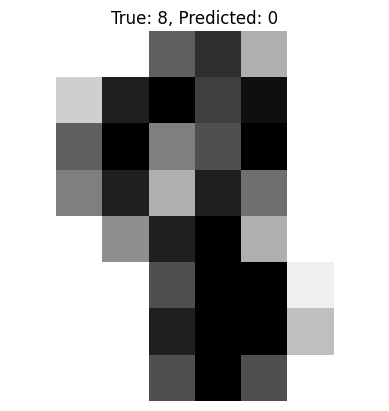

In [ ]:
def show_sample_with_output(model, X_test, y_test, sample_index):
    sample = X_test[sample_index]
    true_class = y_test[sample_index]
    
    input_value = list(map(Value, sample))
    outputs = model(input_value)
    predicted_class = np.argmax([p.data for p in outputs])

    plt.imshow(sample.reshape(8, 8), cmap=plt.cm.gray_r)
    plt.title(f"True: {true_class}, Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

# Show a random sample from the test set
show_sample_with_output(neural_network, X_test, y_test, sample_index=random.randint(0, X_test.shape[0]-1))

## Part 6: Putting It All Together with PyTorch

You've done the hard work. You've built an entire automatic differentiation engine and neural network library from scratch. Now, let's see how modern deep learning frameworks like **PyTorch** allow us to do the same thing with much less code.

This final task is to solve the same handwritten digit recognition problem, but this time using the tools provided by PyTorch. You will notice many parallels to the `Module`, `Layer`, and `Value` objects you created.

First, you'll need to install PyTorch if you haven't already:

In [29]:
%pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


### 6.1 Data Preparation with PyTorch

PyTorch has its own data structures for handling data and creating batches efficiently. The first step is to convert our NumPy arrays into PyTorch `Tensors`.


In [214]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# TASK 6.1: Convert data to PyTorch Tensors and create DataLoaders.

# --- Prepare the training data ---
# 1. Convert training features and labels from NumPy arrays to PyTorch Tensors.
#    Use torch.from_numpy(). Remember to convert them to the correct data type (.float() for features, .long() for labels).
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()

# 2. Create a TensorDataset to bundle features and labels together.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# 3. Create a DataLoader to handle batching and shuffling automatically.
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# --- Prepare the testing data ---
# 4. Do the same for the test set.
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).long()

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Let's check a batch to see what the DataLoader gives us
data_batch, labels_batch = next(iter(train_loader))
print(f"Data batch shape: {data_batch.shape}")
print(f"Labels batch shape: {labels_batch.shape}")

Data batch shape: torch.Size([8, 64])
Labels batch shape: torch.Size([8])


### 6.2 Building the Model in PyTorch

In PyTorch, models are created by creating a class that inherits from `nn.Module`. This is the direct equivalent of the `Module` class you built. Layers like `nn.Linear` are PyTorch's version of your `Layer` class, with weights and biases built-in.


In [215]:
# TASK 6.2: Define the neural network architecture using nn.Module.

class MLP_PyTorch(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the layers of the network. Our network has:
        # 1. A linear layer from 64 inputs to 32 outputs.
        # 2. A ReLU activation function.
        # 3. A final linear layer from 32 inputs to 10 outputs (for the 10 digits).
        # You can try changing the architecture, but this is a good starting point.
        # TODO: Define the layers as class attributes (e.g., self.layer1 = nn.Linear(...))
        self.layer1 = nn.Linear(64, 32)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.layer2 = nn.Linear(32, 16)
        self.activation = nn.ReLU()
        self.layer3 = nn.Linear(16, 10)

    def forward(self, x):
        # This function defines the forward pass, just like your __call__ method.
        # TODO: Pass the input 'x' through the layers you defined in __init__.
        z = self.layer1(x)
        z = self.activation(z)
        z = self.dropout(z)
        z = self.layer2(z)
        z = self.activation(z)
        z = self.layer3(z)
        return z

# Instantiate the model
model = MLP_PyTorch()
print(model)

MLP_PyTorch(
  (layer1): Linear(in_features=64, out_features=32, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (layer2): Linear(in_features=32, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=10, bias=True)
)


### 6.3 Defining the Loss and Optimizer

PyTorch provides standard loss functions and optimizers. For this multi-class classification problem, `CrossEntropyLoss` is the best choice (it conveniently includes the Softmax layer for you). We'll use the Adam optimizer, which is a popular and effective choice.

In [216]:
# TASK 6.3: Instantiate the loss function and optimizer.

# 1. The loss function for multi-class classification.
criterion = nn.CrossEntropyLoss()

# 2. The optimizer that will update our model's parameters.
#    It needs to know which parameters to optimize (model.parameters()).
learning_rate = 0.001
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

### 6.4 The Training Loop in PyTorch

The training loop in PyTorch follows a standard, clean pattern. Compare this to the loop you wrote from scratch!

In [217]:
# TASK 6.4: Complete the PyTorch training loop.

n_epochs = 30

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        # The standard 5-step PyTorch training process:

        # 1. Zero the gradients from the previous iteration.
        optimizer.zero_grad()

        # 2. Perform the forward pass to get model predictions.
        outputs = model(X_batch)

        # 3. Calculate the loss.
        loss = criterion(outputs, y_batch)

        # 4. Perform the backward pass to compute gradients.
        loss.backward()

        # 5. Update the model's weights.
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

print("Training finished!")

Epoch 1/30, Loss: 2.0739
Epoch 2/30, Loss: 1.2064
Epoch 3/30, Loss: 0.7851
Epoch 4/30, Loss: 0.6020
Epoch 5/30, Loss: 0.4942
Epoch 6/30, Loss: 0.4237
Epoch 7/30, Loss: 0.3848
Epoch 8/30, Loss: 0.3706
Epoch 9/30, Loss: 0.3156
Epoch 10/30, Loss: 0.2955
Epoch 11/30, Loss: 0.2770
Epoch 12/30, Loss: 0.2429
Epoch 13/30, Loss: 0.2402
Epoch 14/30, Loss: 0.2459
Epoch 15/30, Loss: 0.2037
Epoch 16/30, Loss: 0.1960
Epoch 17/30, Loss: 0.1948
Epoch 18/30, Loss: 0.1898
Epoch 19/30, Loss: 0.1783
Epoch 20/30, Loss: 0.1804
Epoch 21/30, Loss: 0.1686
Epoch 22/30, Loss: 0.1644
Epoch 23/30, Loss: 0.1577
Epoch 24/30, Loss: 0.1559
Epoch 25/30, Loss: 0.1408
Epoch 26/30, Loss: 0.1408
Epoch 27/30, Loss: 0.1198
Epoch 28/30, Loss: 0.1353
Epoch 29/30, Loss: 0.1312
Epoch 30/30, Loss: 0.1246
Training finished!


### 6.5 Evaluating the PyTorch Model

Finally, let's see how our new model performs on the test set. The evaluation loop is similar, but we tell PyTorch not to calculate gradients to save time and memory.

*(This code is provided for you)*

In [218]:
# Set the model to evaluation mode
model.eval()

correct = 0
total = 0

# Tell PyTorch not to track gradients during evaluation
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # Get predictions
        outputs = model(X_batch)
        
        # The class with the highest value is our prediction
        _, predicted = torch.max(outputs.data, 1)
        
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = 100 * correct / total
print(f'\nAccuracy of the network on the test images: {accuracy:.2f} %')


Accuracy of the network on the test images: 97.50 %


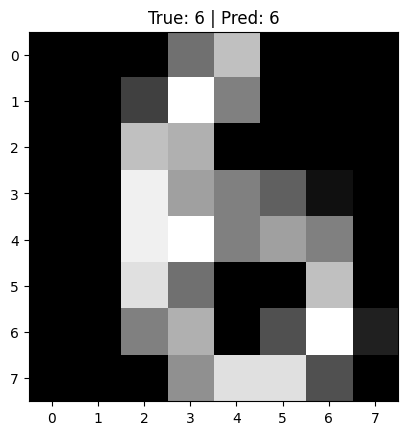

In [ ]:
# --- Example prediction ---
# Take one batch from test_loader
X_example, y_example = next(iter(test_loader))

# Model predictions
outputs = model(X_example)
_, predicted = torch.max(outputs, 1)

# Reshape depending on dataset
plt.imshow(X_example[0].view(8, 8), cmap="gray")

plt.title(f"True: {y_example[0].item()} | Pred: {predicted[0].item()}")
plt.show()

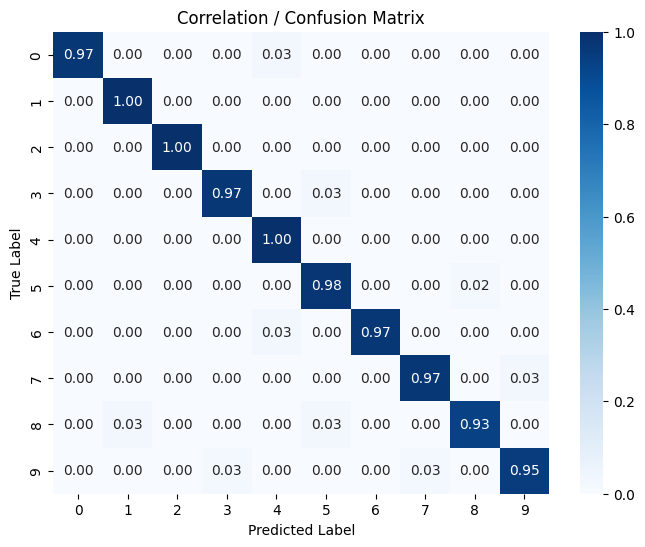

In [223]:
# --- Confusion Matrix ---
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

# Normalize to correlation-like values
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, cmap="Blues", fmt=".2f")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Correlation / Confusion Matrix")
plt.show()

## Bonus Challenges & Further Exploration

Congratulations on building and training a neural network from scratch! If you're ready for more, here are some challenges to improve your model and deepen your understanding of deep learning concepts.

For each of these, you will need to modify your existing classes (`Value`, `Neuron`, `MLP`) or the training loop.

### 1. Implement a Better Loss Function: Cross-Entropy

For classification tasks, Mean Squared Error (MSE) isn't ideal. The standard and more effective loss function is **Cross-Entropy Loss**.

*   **Why?** It's designed to measure the difference between two probability distributions (your model's predictions and the one-hot encoded true labels). It generally leads to faster and more stable training for classifiers.
*   **Your Task:**
    1.  **Softmax Layer:** Before calculating the loss, the raw outputs of your network (called "logits") need to be converted into probabilities. You'll need to implement a **Softmax function** at the end of your network.
        *   *Hint:* The formula is `softmax(z_i) = exp(z_i) / sum(exp(z_j) for all j)`. You already have `exp()` in your `Value` class!
    2.  **Logarithm in `Value`:** The Cross-Entropy formula involves the natural logarithm. Add a `.log()` method to your `Value` class. Don't forget to implement its `_backward` function!
    3.  **Cross-Entropy Formula:** Implement the loss function.
        *   *Hint:* The formula is `Loss = -sum(y_true * log(y_pred))`, where `y_true` is the true label (e.g., 1) and `y_pred` is the predicted probability from the Softmax layer.
    4.  Update your training loop to use the new loss. You should see a significant improvement in training stability and final accuracy!

### 2. Use a Better Activation Function: ReLU ✅ 

`tanh` and `sigmoid` can suffer from the "vanishing gradients" problem in deeper networks. The most common activation function used today is the **Rectified Linear Unit (ReLU)**.

*   **Why?** It's computationally very simple and helps mitigate vanishing gradients, often allowing networks to train faster.
*   **Your Task:**
    1.  Add a `.relu()` method to the `Value` class.
        *   *Hint:* The formula is `relu(x) = max(0, x)`.
        *   *Hint for the gradient:* The derivative is `0` if `x < 0` and `1` if `x > 0`. In your `_backward` function, you can simply check if the original data was positive to decide whether to propagate the gradient.
    2.  Modify your `Neuron` class to use `relu()` for the hidden layers. It's common to still use an appropriate function like Softmax for the final output layer in a classifier.

### 3. Implement Smarter Weight Initialization ✅ `HE initialization`

Initializing weights from `random.uniform(-1, 1)` can be problematic. If weights are too large or too small, training can become unstable. **Principled initialization** methods solve this.

*   **Why?** Methods like Kaiming initialization set the scale of the initial weights based on the number of input and output neurons in a layer, helping gradients flow more smoothly.
*   **Your Task:**
    *   Modify the `__init__` method of your `Neuron` or `Layer` class.
    *   Instead of a fixed range, calculate the initialization range dynamically.

### 4. Improve the Optimizer: Add Momentum

Standard gradient descent can be slow and get stuck. **Momentum** is a technique that helps the optimizer accelerate in the right direction and overcome small local minima.

*   **Why?** It acts like a ball rolling down a hill, accumulating momentum and moving faster than an object that just considers the slope at its current position.
*   **Your Task:**
    1.  This change happens in your training loop's update step.
    2.  For each parameter `p` in your network, you need to keep track of its "velocity," which is a moving average of its past gradients.
    3.  *Hint:* Before the training loop, create a "velocity" dictionary or list that corresponds to your model's parameters, initialized to all zeros.
    4.  The update rule becomes a two-step process:
        *   `velocity = beta * velocity + p.grad` (where `beta` is a hyperparameter, e.g., 0.9)
        *   `p.data -= learning_rate * velocity`

### 5. Add Regularization to Prevent Overfitting: Dropout ✅

If a network is too powerful, it can "memorize" the training data and fail to generalize to new, unseen data (overfitting). **Dropout** is a simple yet powerful technique to combat this.

*   **Why?** It forces the network to learn more robust features by preventing neurons from co-adapting too much.
*   **Your Task:**
    1.  Modify the `__call__` method of your `Layer` class.
    2.  During training, for each neuron's output in the layer, randomly set it to `0` with some probability `p` (e.g., `p=0.2`).
    3.  **Crucial Step (Inverted Dropout):** To ensure the overall magnitude of the layer's output remains the same, you must scale the outputs of the neurons that were *not* dropped out by `1 / (1 - p)`.
    4.  Add a mechanism to turn dropout **OFF** during evaluation/testing. The model should use all its neurons when making final predictions. You could pass a `training=True` flag to the `__call__` method.
